In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'coleaf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5050158%2F8469747%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240521%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240521T065725Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9ca0510cf4b99df86d8c4bebe3a961ec87391368a4a2795ca6538f797809358b06559f606fed1ef61abcc423db482b5c8bb710135547257759a78dbe0c1bdf6be7b3cd691d0403a213bff762cd49efdee5211fa9cf4ca9ecf2949cd61ec79573ac9fc7eda87df5c6c1608be9f9676d4bab307cf17c41c79fe61a36a8dc4055f4b10b3c98fb459fe99362a0618e978112c54a527f4951c9c8041d76def9ee7aea2ea8732b1c1f4ea13a268cc6724bb8e92e62c5bcb9978e814aeae20cfa4e623c7b1072a7395c41c5451ae0f2760583fb03bab0c5416d266e50ac0c56b38974ac872c40406c58fc9882571b387debe8b31144b9a3bc63c7632c2470733ca3774a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/coleaf/CoLeaf DATASET'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (116).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (126).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (1).jpg
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (150).jpg
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (117).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (77).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (67).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (46).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (86).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (34).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (50).JPG
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (20).jpg
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (9).jpg
/kaggle/input/coleaf/CoLeaf DATASET/calcium-Ca/calcium-Ca/Ca (21).jpg
/kaggle/input/cole


# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Base Model Creation</p>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import os


# Define the path to your dataset
dataset_path = '/kaggle/input/coleaf/CoLeaf DATASET'  # Change this to your dataset path

# Load and preprocess data
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

validation_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

# Get the class names directly from the dataset
class_names = train_ds.class_names

# Prepare the datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# EfficientNetB0 base model
efficientnet_base = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
efficientnet_base.trainable = False

# ResNet50 base model
resnet_base = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
resnet_base.trainable = False


Found 1006 files belonging to 10 classes.
Using 805 files for training.
Found 1006 files belonging to 10 classes.
Using 201 files for validation.


# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Define the Model
</p>

In [ ]:
def create_model(base_model, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(num_classes)
    ])
    return model

num_classes = len(class_names)
efficientnet_model = create_model(efficientnet_base, num_classes)
resnet_model = create_model(resnet_base, num_classes)



# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Compile the Model</p>

In [ ]:
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Train the Model
</p>

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Train EfficientNetB0
efficientnet_history = efficientnet_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2293 - loss: 2.1325 - val_accuracy: 0.2886 - val_loss: 2.0747
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2254 - loss: 2.1454 - val_accuracy: 0.2886 - val_loss: 2.0752
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2190 - loss: 2.1444 - val_accuracy: 0.2886 - val_loss: 2.0699
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2347 - loss: 2.1442 - val_accuracy: 0.2886 - val_loss: 2.0749
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2359 - loss: 2.1464 - val_accuracy: 0.2886 - val_loss: 2.0722
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2350 - loss: 2.1570 - val_accuracy: 0.2886 - val_loss: 2.0734
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2346 - loss: 2.1525 - val_accuracy: 0.2886 - val_loss: 2.0724
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2404 - loss: 2.1455 - val_accuracy: 0.

In [ ]:

# Train ResNet50
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100,  # Adjust the number of epochs as needed
    callbacks=[early_stopping]
)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - accuracy: 0.1637 - loss: 2.4368 - val_accuracy: 0.2886 - val_loss: 2.0756
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2351 - loss: 2.1667 - val_accuracy: 0.2886 - val_loss: 2.0882
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.2156 - loss: 2.1899 - val_accuracy: 0.2886 - val_loss: 2.0572
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2586 - loss: 2.0868 - val_accuracy: 0.2886 - val_loss: 2.0683
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2402 - loss: 2.1126 - val_accuracy: 0.2886 - val_loss: 2.0800
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2157 - loss: 2.1393 - val_accuracy: 0.2886 - val_loss: 2.0307
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2374 - loss: 2.1236 - val_accuracy: 0.2886 - val_loss: 2.0415
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2257 - loss: 2.1272 - val_accuracy: 


# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Evaluate the Model
</p>

In [ ]:
def evaluate_model(model, test_ds):
    test_loss, test_accuracy = model.evaluate(test_ds)
    y_pred = model.predict(test_ds)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = np.concatenate([y for _, y in test_ds], axis=0)
    test_f1_score = f1_score(y_true, y_pred_labels, average='weighted')

    print(f'Test Loss: {test_loss:.5f}')
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Test F1-score: {test_f1_score * 100:.2f}%')




# <p style="background-color: blue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">EfficientNetB0
</p>

In [ ]:
# Evaluate EfficientNetB0
evaluate_model(efficientnet_model, validation_ds)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3300 - loss: 2.0284
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 822ms/step
Test Loss: 2.06668
Test Accuracy: 28.86%
Test F1-score: 12.92%


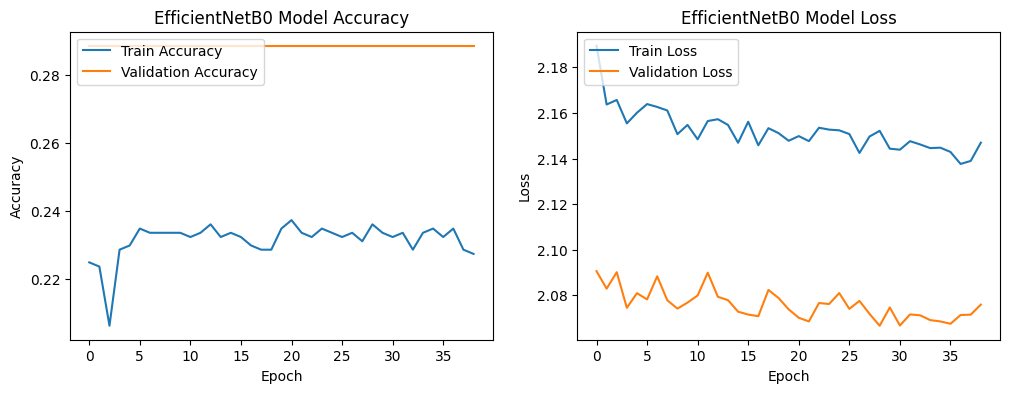

In [ ]:
# Plot EfficientNetB0 history
plot_training_history(efficientnet_history, 'EfficientNetB0')

# <p style="background-color: blue; font-family:calibri; color:white; font-size:90%; font-family:Verdana; text-align:center; border-radius:15px 50px;">ResNet50
</p>


In [ ]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()



In [ ]:
# Evaluate ResNet50
evaluate_model(resnet_model, validation_ds)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4301 - loss: 1.6335
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 588ms/step
Test Loss: 1.69863
Test Accuracy: 38.31%
Test F1-score: 30.38%


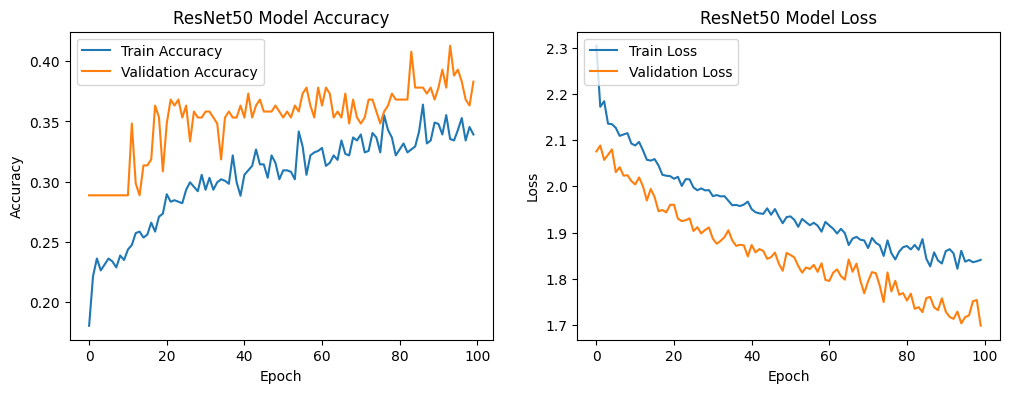

In [ ]:
# Plot ResNet50 history
plot_training_history(resnet_history, 'ResNet50')
